Вы аналитик российской авиакомпании F9, выполняющей внутренние пассажирские перевозки. Важно понять предпочтения пользователей, покупающих билеты на разные направления.

Вам предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие культурные фестивали.

**Шаг 1.  Аналитика средствами Python**

У вас есть файлы, в которых содержатся результаты запросов из предыдущих заданий.

**query_1.csv** — результат первого запроса. В нём содержится такая информация:

- *model* — **модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов *model* в сентябре 2018 года.

**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город (*city*) за день в сентябре 2018 года.

 Для этих двух наборов данных нужно:

- импортировать файлы;
- изучить данные в них;
- проверить типы данных на корректность;
- выбрать топ-10 городов по количеству рейсов;
- построить графики: модели самолётов и количество рейсов, города и количество рейсов, топ-10 городов и количество рейсов;
- сделать выводы по каждому из графиков, пояснить результат.

**Шаг 2.  Проверка гипотезы средствами Python**

**query_last.csv** — результат последнего запроса. В нём следующая информация:

- *week_number* — **номер недели;
- *ticket_amount* — количество проданных билетов за неделю;
- *festival_week —* есть ли на этой неделе фестиваль;
- *festival_name —* название фестиваля.

Проверьте гипотезу: «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».

Пороговое значение *alpha* задайте самостоятельно.

Поясните:

- Как вы формулировали нулевую и альтернативную гипотезы;
- Какой критерий использовали для проверки гипотез и почему.

# 1. Аналитика

In [1]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

import math
from scipy import stats as st

import requests

PATH = 'datasets/'
SEED = 21

Загрузим данные в pandas и посмотрим на них

In [2]:
query_1 = pd.read_csv(os.path.join(PATH, 'query_1.csv'))
query_3 = pd.read_csv(os.path.join(PATH, 'query_3.csv'))
query_last = pd.read_csv(os.path.join(PATH, 'query_last.csv'))

In [3]:
query_1

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [4]:
query_3

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613
...,...,...
96,Чита,1.580645
97,Элиста,4.870968
98,Южно-Сахалинск,4.290323
99,Якутск,2.741935


In [5]:
query_last

,week_number,ticket_amount,festival_week,festival_name
0,30,43568,30.0,Park Live
1,31,51034,31.0,Пикник Афиши
2,32,51675,NaN,NaN
3,33,51378,NaN,NaN
4,34,51492,NaN,NaN
5,35,51360,NaN,NaN
6,36,51386,36.0,Видфест
7,37,51670,NaN,NaN
8,38,51518,NaN,NaN
9,39,51623,NaN,NaN


Проверим типы данных

In [6]:
query_1.info()
query_3.info()
query_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   week_number    10 non-null     int64  
 1   ticket_amount  10 non-null     int64  
 2   festival_week  3 non-null      float64
 3   fes

Как мы видим типы соотвествуют данным

Выберем топ 10 городов по количеству рейсов

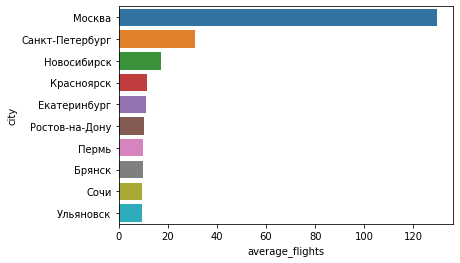

In [7]:
sns.barplot(x='average_flights',
            y='city',
            data=query_3.sort_values(by='average_flights', ascending=False).head(10))

Посторим график модели самолётов и количество рейсов

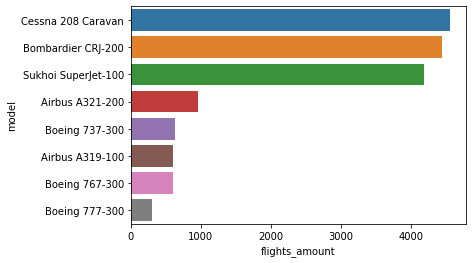

In [8]:
sns.barplot(x='flights_amount',
            y='model',
            data=query_1.sort_values(by='flights_amount', ascending=False))

Как мы видим больше все полетов у самолета малой авиации и пассаржиских с малой дальностью

Посторим график города и количество рейсов на карте

1. Получим координаты городов от геокодера яндекса
1. Построим bubble map plot из plotly

In [9]:
def getLonLatYandex(row):
    
    params = {
        'geocode': row['city'],
        'apikey': 'my_key',
        'format': 'json'
    }
    
    r = requests.get('https://geocode-maps.yandex.ru/1.x', params=params)
    
    data = r.json()['response']['GeoObjectCollection']['featureMember']
    coord = [float(x) for x in data[0]['GeoObject']['Point']['pos'].split(' ')]
    
    assert len(coord) == 2
    
    row['lon'] = coord[0]
    row['lat'] = coord[1]
    
    return row

In [10]:
query_3 = query_3.apply(getLonLatYandex, axis=1)

In [11]:
query_3.sample(5, random_state=SEED)

,city,average_flights,lon,lat
21,Иваново,1.000000,40.973921,57.000348
85,Урай,2.000000,64.803216,60.128951
62,Пенза,4.000000,45.018316,53.195042
31,Комсомольск-на-Амуре,1.000000,137.007948,50.549923
64,Петрозаводск,5.870968,34.346878,61.785017


In [12]:
query_3['text'] = query_3['city'] + '<br>Average flights ' + query_3['average_flights'].astype(str)

color_map = {
    'Москва': '#9F1E54',
    'Санкт-Петербург': '#B11F79',
    'Новосибирск': '#C35899',
    'Остальные': '#D492BB',
    }

cities = []
scale = 2

fig = go.Figure()

for city in color_map:
    if city == 'Остальные':
        df_sub = query_3[~query_3['city'].str.contains('|'.join(list(color_map.keys())[0:3]),
                                      regex=True)]
    else:
        df_sub = query_3.loc[query_3['city']==city, :]
        
    fig.add_trace(go.Scattergeo(
        #locations = ['Russian Federation'],
        #locationmode = 'ISO-3',
        lon = df_sub['lon'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
                    size = df_sub['average_flights']/scale,
                    color = color_map[city],
                    line_color='black',
                    line_width=1.5),
        name = city))
        
fig.update_layout(
        title_text = 'Average flights count by cities',
        showlegend = True,
        geo = dict(
            #resolution=50,
            scope = 'world',
            landcolor = 'rgb(217, 217, 217)',
            showcountries=True, countrycolor="Black",
            showsubunits=True, subunitcolor="Black",
            projection_type="mercator",
            lataxis_range=[52, 81], lonaxis_range=[19, 190]
        )
    )

# fig.show() не работает для github

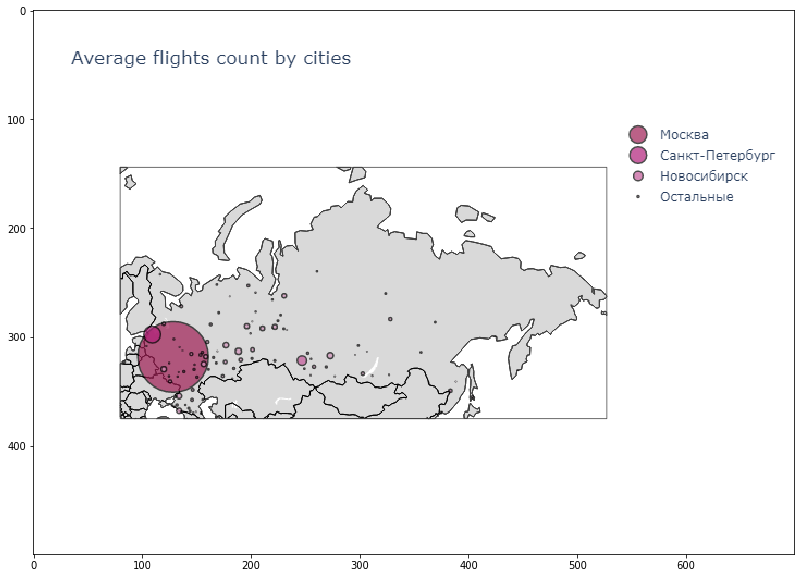

In [13]:
fig.write_image("map.png")
im = Image.open("map.png")

plt.figure(figsize=(20,10))
plt.imshow(im)

Видно что больше всего рейсов из Москвы и городов миллиоников Санкт-Петербург и Новосибирск

# 2. Проверка гипотезы

Проверим гипотезу: «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».

Сформулируем гипотезы:
1. H0: Средний спрос на билеты во время фестивалей **не** отличается от среднего спроса на билеты в обычное время
1. H1: Средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время

По сути нам надо проверить равенство средних в выборке количество билетов в недели когда есть фестивали и когда их нет. Используем для этого t-test Стьюдента из пакета `scipy.stats`

In [14]:
sample1 = query_last.loc[query_last['festival_week'].isna(), 'ticket_amount']
sample2 = query_last.loc[~query_last['festival_week'].isna(), 'ticket_amount']

assert (sample1.shape[0] + sample2.shape[0]) == query_last.shape[0]

In [15]:
res = st.ttest_ind(sample1, sample2, equal_var=True)
res.pvalue

0.09688869045922928

Так выборки предаположительно из одной генеральной совокупность, то предроложим и равенство дисперсий `equal_var=True`

Как мы видим pvalue > 0.05, соответвенно мы не отвергаем 0 гипотезу.

Мы не можем утверждать о статистически значимой разнице между спрос на билеты во время фестивалей и в обычное время